In [1]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=f0882a1d4d79d3ba1315c69657667ee4c96fdc79dff6441778b1c491f81e2d90
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
import umap as ump
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ss
from sklearn.cluster import KMeans
from google.colab import drive
import os
from os import listdir

print('Successful imports')

Successful imports


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/Machine Learning in healthcare/Final project'

/content/gdrive/MyDrive/Machine Learning in healthcare/Final project


 ### IDEAS

 CLUSTERING - GMM

 DIMENSIONALITY REDUCTION - Umap + plot to observe data separation in latent space

 Study pairwise mutual information + HSIC + correlations

 Association rules, observe what usually goes together A PRIORI

 Graph analysis on graph version of latent space and run algorithms for strongly connected components. Something that accounts for intra-class noise and difference between other classes (or clusters)



## Feature selection

In [ ]:
data = pd.read_csv('Eureca_Adapted.csv', low_memory=False)

In [ ]:
all = data.columns
cols = []

In [ ]:
# series of interesting information,
mixture = ['type', 'suicide','EST_CIV', 'children', 'ideation_of_suicide', 'desire_of_death', 'Planification_of_suicide', 'tm', 'tm2',
        'tabacco_act', 'niv_edu','his_fam_suicide_behavior', 'his_fam_suicide', 'his_fam_suicide_attempt',
        'desire_of_death', 'Planification_of_suicide', 'dd_depre', 'dd_bipolar', 'dd_sz', 'dd_psychotic']

In [ ]:
# BDHI and BIS scales
BDHIS = [col for col in all if ("BDHI_" in col)] # usando subtotales BDHI_,
BIS = [col for col in all if ("BIS10_" in col)] # cogemos subtotales latentes BIS, resultado final es suma de los tres subtotales



In [ ]:
print(BDHIS)
print(BIS)

['BDHI_Impul', 'BDHI_Hostind', 'BDHI_Irritab', 'BDHI_Negativ', 'BDHI_Ressent', 'BDHI_Suspic', 'BDHI_Hostivb', 'BDHI_Culpab']
['BIS10_Impulc', 'BIS10_Impulm', 'BIS10_impulnp']


In [ ]:
# polymorphisms and other data are in the last 30 variables
extra = list(data.columns[-30:])
for col in mixture +  BDHIS +  BIS + extra:
  cols.append(col)


In [ ]:
print(f"Original data dimension: {len(all)}")
print(f"Current subset dimension: {len(cols)}")


Original data dimension: 604
Current subset dimension: 61


In [ ]:
reducedFeatures = mixture + BIS + BDHIS + extra
# save feature subset
subset = data[reducedFeatures]
subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
subset.drop(columns=BIS, inplace=True)

subset.to_csv('Eureca2.0.csv', index=False)

<ipython-input-12-ed54b08e2e16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['BIS'] = subset[BIS[0]] + subset[BIS[1]] + subset[BIS[2]]
<ipython-input-12-ed54b08e2e16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop(columns=BIS, inplace=True)


## Exploratory Data analysis: Understanding of our data

## Patient profiling

In this section we profile patients based on different clustering and dimensionality reduction schemes.

In [ ]:
# reading feature subset
df = pd.read_csv('Eureca2.0.csv')

In [ ]:
df.head()

,type,suicide,EST_CIV,children,ideation_of_suicide,desire_of_death,Planification_of_suicide,tm,tm2,tabacco_act,...,TPH1_T8687,TPH2_8997,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,BIS
0,12,0,2,1,2,2,2,1,,1,...,,,AA,GG,,GG,,2 3,B H,311228
1,7,,,1,,2,,1,,,...,,,AA,,,AG,,2,H,281931
2,12,0,2,1,2,2,2,1,,0,...,,,AA,GG,,GG,,2,H,152418
3,12,0,2,1,1,1,0,1,,1,...,,,,,,,,,,40
4,11,,3,,,,,1,,,...,,,,,,,,2,H,


#### UMAP + GMM


UMAP works by modeling the relationships between data points in the high-dimensional space and finding a low-dimensional representation that preserves these relationships. Unlike traditional methods like t-SNE, UMAP provides a more scalable and computationally efficient solution.


______
1. The first issue tackled lies in the fact that UMAP only works with numeric variables, but that is not the case in our dataset. The variables corresponding to the polymorphisms take a very small subset of different nucleotide combinations, dummy variable encoding is therefore used.

In [ ]:

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA


class Embedder:
    def __init__(self, model_name, num_components=1, max_length=32):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_components = num_components
        self.max_length = max_length

    def _get_bert_embeddings(self, documents):
        tokenized_texts = [self.tokenizer(document, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length) for document in documents]
        input_ids = torch.cat([t['input_ids'] for t in tokenized_texts], dim=0)
        attention_mask = torch.cat([t['attention_mask'] for t in tokenized_texts], dim=0)

        with torch.no_grad():
            output = self.model(input_ids, attention_mask=attention_mask)

        embeddings = output.last_hidden_state.mean(dim=1).numpy()
        print('Embeddings successfully completed')
        return embeddings
    def fit_transform(self, documents):
        embeddings = self._get_bert_embeddings(documents)

        # Reduce dimensionality to 1D using PCA
        pca = PCA(n_components=self.num_components)
        reduced_embeddings = pca.fit_transform(embeddings)

        return reduced_embeddings

In [ ]:
df.head()

,type,suicide,EST_CIV,children,ideation_of_suicide,desire_of_death,Planification_of_suicide,tm,tm2,tabacco_act,...,TPH1_T8687,TPH2_8997,TPH2_9000_Eco72_1,TPH2_9000_Aci_I,TPH2_Intron5,TPH2_Exon7,TPH2_Intron9,MAOA_Promo,MAOA_promo_activite,BIS
0,12,0,2,1,2,2,2,1,,1,...,,,AA,GG,,GG,,2 3,B H,311228
1,7,,,1,,2,,1,,,...,,,AA,,,AG,,2,H,281931
2,12,0,2,1,2,2,2,1,,0,...,,,AA,GG,,GG,,2,H,152418
3,12,0,2,1,1,1,0,1,,1,...,,,,,,,,,,40
4,11,,3,,,,,1,,,...,,,,,,,,2,H,


In [ ]:
import copy

# don't run this unless you don't have copy of dataset, there is a reading cell below already
embd = Embedder('bert-base-uncased')
scols= df.select_dtypes(include=['object']).columns
df2 = df.copy()
for col in scols:
  # compute embeddings of list of unique values and perform replacement
  documents = df[col].unique().tolist()
  values = embd.fit_transform(documents)
  rep = dict(zip(documents, values))
  df2[col] = df2[col].replace(rep)

Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings successfully completed
Embeddings suc

In [21]:
# saving encoded version
df2.to_csv('Eureca2.0_embed.csv')

In [5]:
# read
df2 = pd.read_csv('Eureca2.0_embed.csv')

In [ ]:
len(df.columns)

59

In [22]:
# loading read_csv
reducer = ump.UMAP(random_state=42)
embeddings = reducer.fit_transform(df2)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [7]:
# 3d version
"""
reducer = ump.UMAP(n_components=3, random_state=42)

embeddings = reducer.fit_transform(df2)

"""

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


'\n'

2. Studying the correlations between the original features and the UMAP dimensions, helps to understand which variables have the most impact in the components of the reduced data. The following code displays, for both components, the 10 features with the highest correlation with the UMAP component in absolute value

In [25]:
print('CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS')
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))

# Calculate correlations
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrames to store the results for UMAP1 and UMAP2
correlation_df_umap1 = pd.DataFrame(correlations[:, 0], columns=['UMAP1'], index=df2.columns)
correlation_df_umap2 = pd.DataFrame(correlations[:, 1], columns=['UMAP2'], index=df2.columns)

# Get top 10 correlations for UMAP1
top_correlations_umap1 = correlation_df_umap1.abs().nlargest(10, 'UMAP1')

# Print the top 10 correlations with sign for UMAP1
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap1.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

# Get top 10 correlations for UMAP2
top_correlations_umap2 = correlation_df_umap2.abs().nlargest(10, 'UMAP2')

# Print the top 10 correlations with sign for UMAP2
print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap2.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

CORRELATION STUDY FOR 2-D UMAP EMBEDDINGS
UMAP1:
Feature: type, Correlation: (-) 0.3582
Feature: Planification_of_suicide, Correlation: (+) 0.2856
Feature: Planification_of_suicide.1, Correlation: (+) 0.2856
Feature: ideation_of_suicide, Correlation: (+) 0.2853
Feature: TPH1_Intron3, Correlation: (-) 0.2339
Feature: HT1A, Correlation: (-) 0.1823
Feature: TPH1_T8687, Correlation: (-) 0.1809
Feature: HT1B_861, Correlation: (-) 0.1804


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide



Feature: VHTTP_Intron2, Correlation: (+) 0.1700
Feature: COMT, Correlation: (-) 0.1694

UMAP2:
Feature: his_fam_suicide_behavior, Correlation: (+) 0.1727
Feature: desire_of_death, Correlation: (+) 0.1693
Feature: desire_of_death.1, Correlation: (+) 0.1693
Feature: his_fam_suicide_attempt, Correlation: (+) 0.1653
Feature: VHTTP_Intron2, Correlation: (-) 0.1602
Feature: his_fam_suicide, Correlation: (+) 0.1588
Feature: EST_CIV, Correlation: (+) 0.1310
Feature: niv_edu, Correlation: (+) 0.1081
Feature: BDHI_Negativ, Correlation: (+) 0.0972
Feature: DOS_prolactine, Correlation: (+) 0.0971


In [8]:

# 3d version
"""
correlations = np.zeros((df2.shape[1], embeddings.shape[1]))
for i in range(df2.shape[1]):
    for j in range(embeddings.shape[1]):
        correlations[i, j] = np.corrcoef(df2.iloc[:, i], embeddings[:, j], rowvar=False)[0, 1]

# Create DataFrame to store the results for UMAP dimensions
correlation_df_umap = pd.DataFrame(correlations, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df2.columns)

# Get top 10 correlations for each UMAP dimension
top_correlations_umap1 = correlation_df_umap.abs().nlargest(10, 'UMAP1')
top_correlations_umap2 = correlation_df_umap.abs().nlargest(10, 'UMAP2')
top_correlations_umap3 = correlation_df_umap.abs().nlargest(10, 'UMAP3')

# Print the top 10 correlations with sign for each UMAP dimension
print("UMAP1:")
for feature, correlation in top_correlations_umap1.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP1'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP1']:.4f}")

print("\nUMAP2:")
for feature, correlation in top_correlations_umap2.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP2'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP2']:.4f}")

print("\nUMAP3:")
for feature, correlation in top_correlations_umap3.iterrows():
    sign = '-' if correlation_df_umap.loc[feature, 'UMAP3'] < 0 else '+'
    print(f"Feature: {feature}, Correlation: ({sign}) {correlation['UMAP3']:.4f}")
"""

UMAP1:
Feature: dd_sz, Correlation: (-) 0.3690
Feature: TPH1_Intron7, Correlation: (-) 0.2452
Feature: TPH1_promo, Correlation: (-) 0.2397
Feature: TPH1_Intron4, Correlation: (-) 0.2356
Feature: TPH2_9000_Eco72_1, Correlation: (-) 0.2341
Feature: TPH2_9000_Aci_I, Correlation: (-) 0.2335
Feature: COMT, Correlation: (-) 0.2306
Feature: HT1A, Correlation: (-) 0.2237
Feature: TPH2_Exon7, Correlation: (-) 0.2233
Feature: HT1B_861, Correlation: (-) 0.2232

UMAP2:
Feature: Unnamed: 0, Correlation: (-) 0.3032
Feature: type, Correlation: (+) 0.1997
Feature: ideation_of_suicide, Correlation: (-) 0.1709
Feature: Planification_of_suicide, Correlation: (-) 0.1671
Feature: Planification_of_suicide.1, Correlation: (-) 0.1671
Feature: BDHI_Ressent, Correlation: (-) 0.1564
Feature: BDHI_Negativ, Correlation: (-) 0.1543
Feature: desire_of_death, Correlation: (-) 0.1542
Feature: desire_of_death.1, Correlation: (-) 0.1542
Feature: BDHI_Hostind, Correlation: (-) 0.1537

UMAP3:
Feature: Unnamed: 0, Correlat

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


'\n'

3. Fitting GMM to data based on optimal BIC.

In [53]:

# UMAP + GMM clustering through optimal Bayesian Information Criterion

# this cell is the same for 2d and 3d data
# we need to encode string variables

bics = []
aics = []
ks = range(1,7)
for ns in ks:
  gmm = GMM(n_components=ns, random_state=42)
  gmm.fit(embeddings)
  labels = gmm.predict(embeddings)
  bics.append(gmm.bic(embeddings))
  aics.append(gmm.aic(embeddings))

opt = ks[bics.index(min(bics))]
opt2 = ks[aics.index(min(aics))]
gmm = GMM(n_components=opt, random_state=42)
labs = gmm.fit_predict(embeddings)
gmm1 = GMM(n_components=opt2, random_state=42)
labs2 = gmm1.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
  dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
  dfr = pd.DataFrame(embeddings, columns = ['UMAP1', 'UMAP2', 'UMAP3'])
dfr['profileBIC'] = labs
dfr['profileAIC'] = labs2


In [60]:
np.unique(labs2)

array([0, 1, 2, 3, 4, 5])

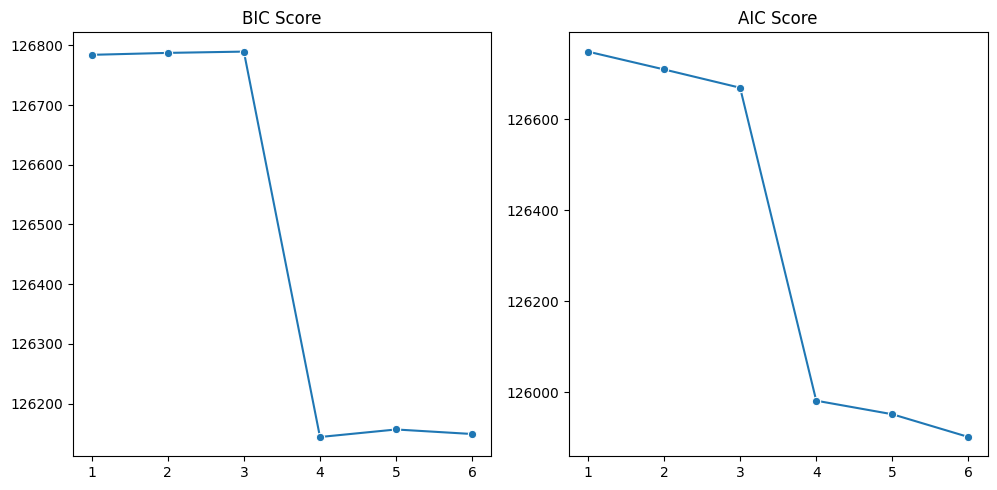

In [54]:
plt.figure(figsize=(20, 5))

# BIC Plot
plt.subplot(1, 4, 1)
sns.lineplot(x=ks, y=bics, marker='o')
plt.title('BIC Score')

# AIC Plot
plt.subplot(1, 4, 2)
sns.lineplot(x=ks, y=aics, marker='o')
plt.title('AIC Score')




plt.tight_layout()
plt.show()

The optimal value for the components in terms of BIC, is 4, in terms of AIC, it is 6, and in terms of log-likelihood it is also 6.

In [ ]:
dfr['profile'].value_counts()

1    1982
0    1631
5    1435
2    1425
4    1249
3     973
Name: profile, dtype: int64

In [11]:
! pip install plotly

In [12]:
"""3d version to observe patient profiles"""
import plotly.express as px


dfr.to_csv('Eureca2.0_umapGMM3d.csv')

# Create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(dfr, x='UMAP1', y='UMAP2', z='UMAP3', color='profile', opacity=0.8)

# Update layout for better visibility
fig.update_layout(scene=dict(zaxis=dict(range=[dfr['UMAP3'].min(), dfr['UMAP3'].max()])))

# Show the interactive plot
fig.show()

In [28]:
cdg =  dfr['profile'].value_counts(normalize=True)
cluster_distribution_gmm = dfr['profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-3d):")
print(cdg)

Cluster Distribution (GMM-3d):
2    0.432662
1    0.244853
3    0.162507
0    0.159977
Name: profile, dtype: float64


In [55]:
dfr.to_csv('Eureca2.0_umapGMM.csv')

In [ ]:
# READING DATA
# dfr = pd.read_csv('Eureca2.0_umapGMM.csv')
# dfr.drop('ordered_profile', axis=1, inplace=True)

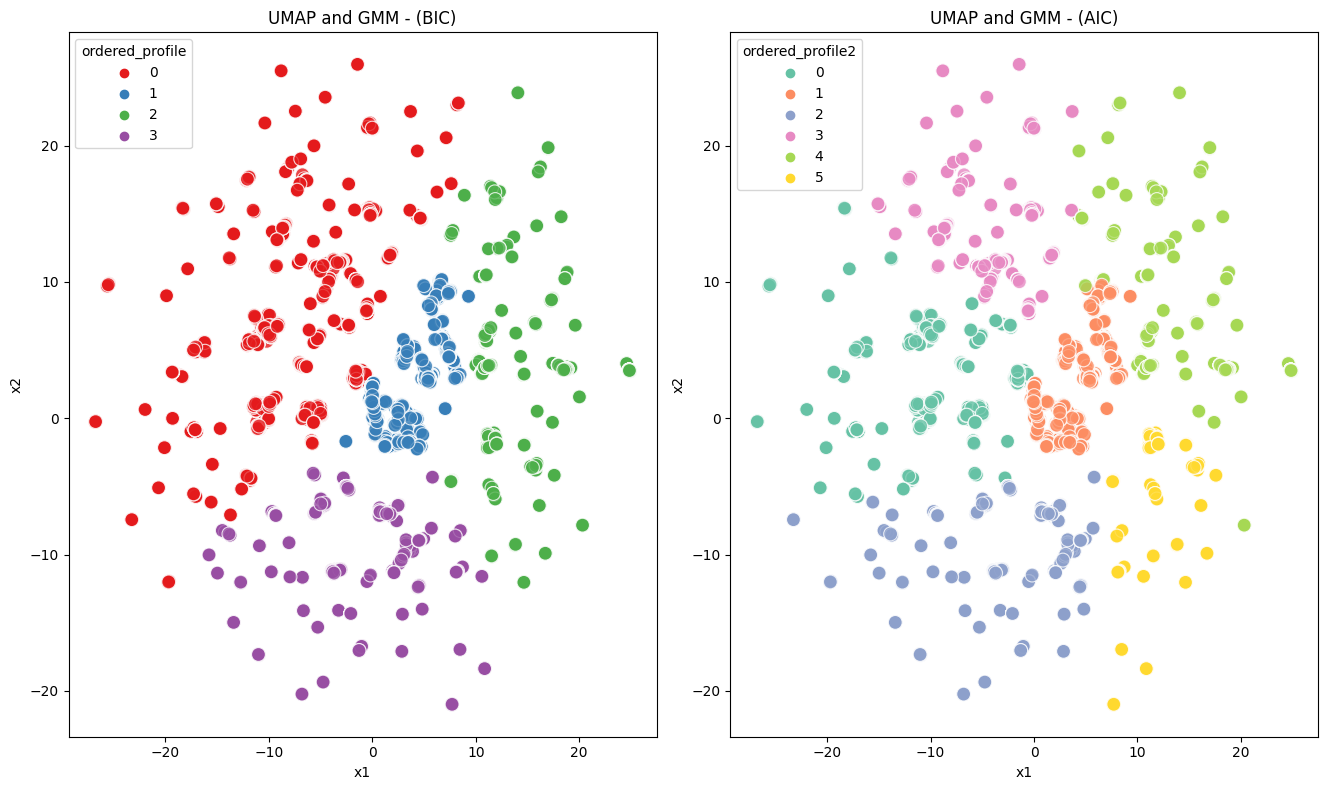

In [66]:


# results without decision regions

cdg=  dfr['profileBIC'].value_counts(normalize=True)
oci = cdg.index
cdg2 =  dfr['profileAIC'].value_counts(normalize=True)
orci = cdg2.index
dfr2 = dfr.copy()
# Create ordered_profile2 and ordered_profile3 columns
dfr2['ordered_profile'] = dfr2['profileBIC'].map(dict(zip(oci, range(len(oci)))))
dfr2['ordered_profile2'] = dfr2['profileAIC'].map(dict(zip(orci, range(len(orci)))))
# Set up subplots
plt.figure(figsize=(20, 8))

# Plot for ordered_profile
plt.subplot(1, 3, 1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile', data=dfr2, palette="Set1", s=100, alpha=0.8)
plt.title('UMAP and GMM - (BIC)')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot for ordered_profile2
plt.subplot(1, 3, 2)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='ordered_profile2', data=dfr2, palette="Set2", s=100, alpha=0.8)
plt.title('UMAP and GMM - (AIC)')
plt.xlabel('x1')
plt.ylabel('x2')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



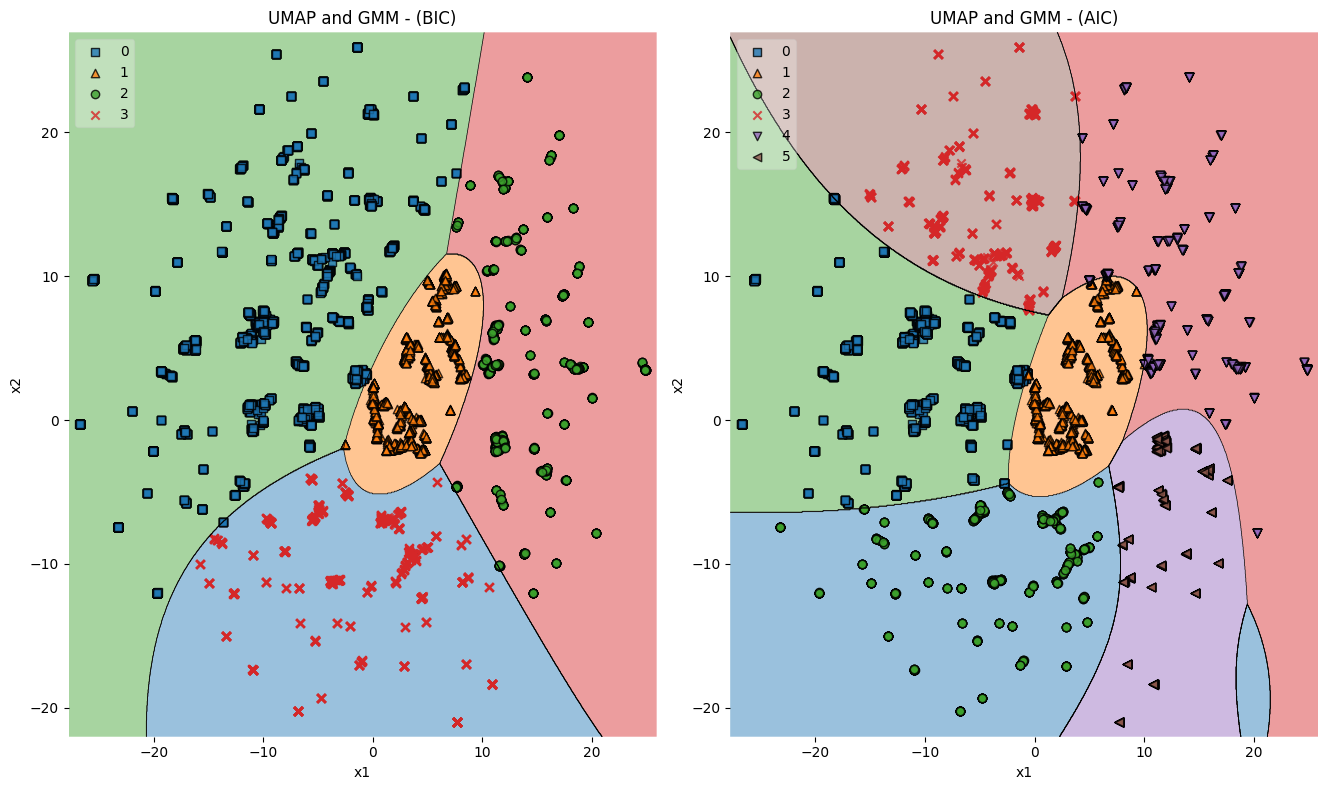

In [70]:
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(20, 8))

# Plot for ordered_profile
plt.subplot(1, 3, 1)
plot_decision_regions(embeddings, dfr2['ordered_profile'].values, clf=gmm, legend=2)
plt.title('UMAP and GMM - (BIC)')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot for ordered_profile2
plt.subplot(1, 3, 2)
plot_decision_regions(embeddings, dfr2['ordered_profile2'].values, clf=gmm1, legend=2)
plt.title('UMAP and GMM - (AIC)')
plt.xlabel('x1')
plt.ylabel('x2')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We now commence by analyzing the results.

In [72]:
cluster_distribution_gmm = dfr2['ordered_profile'].value_counts(normalize=True)
print("Cluster Distribution (GMM-2d):")
print(cdg)

Cluster Distribution (GMM-2d):
2    0.432662
1    0.244853
3    0.162507
0    0.159977
Name: profileBIC, dtype: float64


In [74]:
cluster_distribution_gmm = dfr2['ordered_profile2'].value_counts(normalize=True)
print("Cluster Distribution (GMM-2d):")
print(cdg2)

Cluster Distribution (GMM-2d):
2    0.266935
1    0.232892
0    0.147786
5    0.146176
3    0.135710
4    0.070500
Name: profileAIC, dtype: float64


POR COMENTAR

In [76]:
# 2d
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm.covariances_

print("\nCluster Centers 2-d (GMM-BIC):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 2-d (GMM-BIC):
       UMAP1     UMAP2
0  -2.132719 -8.276616
1   3.969898  2.599885
2  -7.182151  7.304172
3  12.653517  4.332399

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[53.89460038 -7.6565822 ]
 [-7.6565822  34.42932906]]

Cluster 1 Covariance Matrix:
[[10.22720916  8.00976049]
 [ 8.00976049 16.41800593]]

Cluster 2 Covariance Matrix:
[[56.95088383 15.62260783]
 [15.62260783 56.73051145]]

Cluster 3 Covariance Matrix:
[[27.97964914 -0.75524301]
 [-0.75524301 64.26849818]]


All of the profiles, have very anisotropic covariance matrices.

In [75]:
cluster_centers_gmm = pd.DataFrame(gmm.means_, columns=['UMAP1', 'UMAP2'])
cluster_covariance_gmm = gmm1.covariances_

print("\nCluster Centers 2-d (GMM-AIC):")
print(cluster_centers_gmm)
print("\nCluster Covariance Matrices (GMM):")
for i, cov_matrix in enumerate(cluster_covariance_gmm):
    print(f"\nCluster {i} Covariance Matrix:")
    print(cov_matrix)


Cluster Centers 2-d (GMM):
       UMAP1     UMAP2
0  -2.132719 -8.276616
1   3.969898  2.599885
2  -7.182151  7.304172
3  12.653517  4.332399

Cluster Covariance Matrices (GMM):

Cluster 0 Covariance Matrix:
[[57.18050038  0.68322657]
 [ 0.68322657 19.69969434]]

Cluster 1 Covariance Matrix:
[[10.19571845  6.92434116]
 [ 6.92434116 13.89155994]]

Cluster 2 Covariance Matrix:
[[48.28453635 -6.39972386]
 [-6.39972386 29.05639667]]

Cluster 3 Covariance Matrix:
[[ 44.53966782 -13.10882382]
 [-13.10882382  52.11319852]]

Cluster 4 Covariance Matrix:
[[15.93567875 14.16525326]
 [14.16525326 54.88127798]]

Cluster 5 Covariance Matrix:
[[37.55426588  2.7137942 ]
 [ 2.7137942  28.69690542]]


Similarly to the previous case, all covariance matrices are very anistropic, with variances being very irregularly spread out through the UMAP components

#### UMAP + KMEANS

Fitting KMeans to 2-d and 3-d data obtained through UMAP based on optimal silhoutte score

In [77]:
wss = []  # within-cluster sum of squares
sscores = []  # silhouette scores
ks = range(2, 8)  # Adjust the range based on your needs

for n_clusters in ks:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=1000)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    wss.append(kmeans.inertia_)  # Inertia is the WSS
    sscores.append(ss(embeddings, labels))

optimal_k_wss = ks[np.argmin(wss)]

# Find the optimal number of clusters based on silhouette score
optimal_k_silhouette = ks[np.argmax(sscores)]

# KMeans clustering with optimal_k_silhouette
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=1000)
labels_silhouette = kmeans_silhouette.fit_predict(embeddings)

if np.shape(embeddings)[1] == 2:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2'])
else:
    dfr = pd.DataFrame(embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])


In [78]:
dfr['profile'] = labels_silhouette

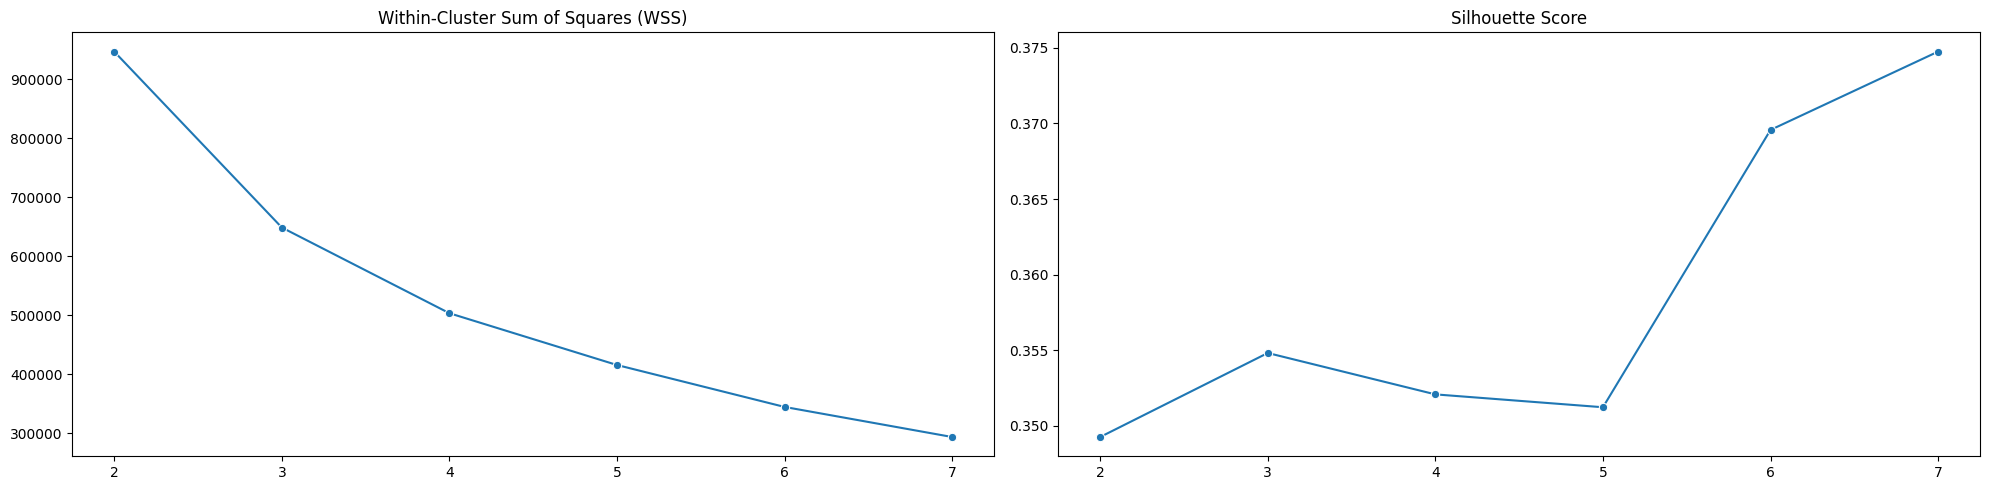

In [79]:

# Plotting
plt.figure(figsize=(20, 5))

# WSS Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=ks, y=wss, marker='o')
plt.title('Within-Cluster Sum of Squares (WSS)')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=ks, y=sscores, marker='o')
plt.title('Silhouette Score')


plt.tight_layout()
plt.show()


In [85]:
# setting clf as gmm, we can observe kmeans groups on gmm with k=3
# setting clf as gmm1, we can osbserve kmeans groups on gmm with k=6
# plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=gmm1, legend=2)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



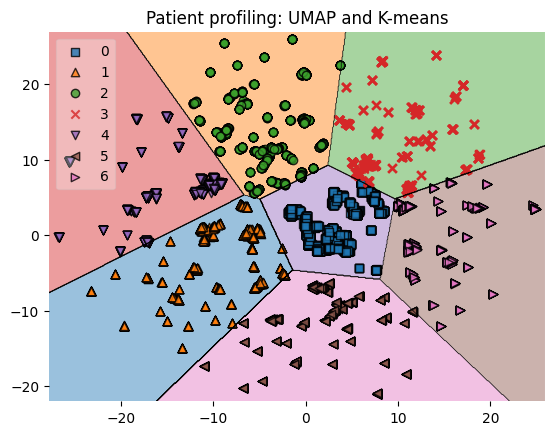

In [87]:
# KMeans clustering with optimal_k_wss Plot

cdg =  dfr['profile'].value_counts(normalize=True)
ordered_cluster_indices = cdg.index
dfr['ordered_profile'] = dfr['profile'].map(dict(zip(ordered_cluster_indices, range(len(ordered_cluster_indices)))))
plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=kmeans_silhouette, legend=2)
# sns.scatterplot(x=dfr.iloc[:, 0], y=dfr.iloc[:, 1], hue=labels_silhouette, palette='viridis')
plt.title(f'Patient profiling: UMAP and K-means')
plt.show()

As K-means is in fact a mixture model where isotropic variances and uniform component weights are assumed, the result of clustering through KMeans is very somewhat similar, as most samples are correctly grouped but there are a number of samples which contradict the decision boundaries observed.

In [ ]:
# plotting the actual decision regions inferred from the kmeans_silhouette
# plot_decision_regions(embeddings, dfr['ordered_profile'].values, clf=kmeans_silhouette, legend=2)

#### Estimating the conditional distribution of the type of patient through Bayesian networks

In [13]:
! pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.3 MB/s eta 0:00:00


In [18]:
df2.drop('Unnamed: 0', axis=1,inplace=True)

In [20]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination

optimal_components = {}

# Loop through each variable and find optimal number of components using BIC
for var in df2.columns:
    if var != 'type':
        # Extract variable data
        data = df2[var].values.reshape(-1, 1)

        # Initialize a range of candidate components
        n_components_range = range(1, 6)  # You can adjust this range based on your data

        # Initialize variables to store optimal values
        best_bic = np.inf
        best_components = 1

        # Loop through candidate components and find optimal
        for n_components in n_components_range:
            gmm = GMM(n_components=n_components)
            gmm.fit(data)
            bic = gmm.bic(data)

            if bic < best_bic:
                best_bic = bic
                best_components = n_components

        # Store the optimal number of components for the variable
        optimal_components[var] = best_components

# Print the optimal number of components for each variable
for var, components in optimal_components.items():
    print(f"Optimal components for {var}: {components}")

# Define the Bayesian Network Structure dynamically
edges = [(var, 'type') for var in df2.columns if var != 'type']
model = BayesianModel(edges)

# Learning the parameters from data using optimal components
gmm_priors = {}
for var, components in optimal_components.items():
    if var != 'type':
        gmm_prior = GMM(n_components=components)
        gmm_prior.fit(df2[var].values.reshape(-1, 1))  # You would use your actual data
        gmm_priors[var] = gmm_prior

# Performing inference
evidence = {var: 1 for var in df2.columns if var != 'type'}  # Assuming all genes are observed
inference = VariableElimination(model)
posterior = inference.map_query(variables=['type'], evidence=evidence)

print("Estimated 'type':", posterior.values[0])

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.

/usr/local

Optimal components for suicide: 3
Optimal components for EST_CIV: 5
Optimal components for children: 3
Optimal components for ideation_of_suicide: 4
Optimal components for desire_of_death: 4
Optimal components for Planification_of_suicide: 4
Optimal components for tm: 3
Optimal components for tm2: 1
Optimal components for tabacco_act: 3
Optimal components for niv_edu: 4
Optimal components for his_fam_suicide_behavior: 3
Optimal components for his_fam_suicide: 3
Optimal components for his_fam_suicide_attempt: 3
Optimal components for desire_of_death.1: 4
Optimal components for Planification_of_suicide.1: 4
Optimal components for dd_depre: 3
Optimal components for dd_bipolar: 3
Optimal components for dd_sz: 3
Optimal components for dd_psychotic: 3
Optimal components for BDHI_Impul: 2
Optimal components for BDHI_Hostind: 5
Optimal components for BDHI_Irritab: 5
Optimal components for BDHI_Negativ: 5
Optimal components for BDHI_Ressent: 5
Optimal components for BDHI_Suspic: 2
Optimal compo

ValueError: ignored